In [ ]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
import cPickle as pickle

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model

import logging
from logging import info

from thesis.utils.metrics import *

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [ ]:
MIN_DOCUMENTS = 5
TOP_N_FEATURES = 10000

RANDOM_SEED = 10000
random.seed(RANDOM_SEED)

In [ ]:
SVM_ITERATIONS = 100
SVM_CONVERGENCE = 0.001
SVM_REG = 0.001
SVM_CLASS_WEIGHTS = None
SVM_MODEL_NAME = 'svm_iter_{}_reg_{}_classweights_{}'.format(SVM_ITERATIONS, SVM_REG, str(SVM_CLASS_WEIGHTS))

In [3]:
IS_SAMPLE = False
TRAINING_SAMPLE_PERCENTAGE = 0.001
MIN_TRAINING_SAMPLES = 20

In [20]:


root_location = "/big/s/shalaby/"
exports_location = root_location + "exported_data/"
svm_location = root_location + "benchmarking_svm/"


training_file = root_location + "docs_output.json"

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
doc_lengths_map_output_file = exports_location + "doc_lengths_map.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"


In [ ]:
#sc = SparkContext("", "Generate Inverted Index Job")
es_server = "deka.cip.ifi.lmu.de"
es_port = "9200"

original_parent_save_location = "hdfs://deka.cip.ifi.lmu.de/svm/new/"
save_parent_location = original_parent_save_location
sample_save_parent_location = save_parent_location + "sample/"
if IS_SAMPLE: 
    save_parent_location = save_parent_location + "sample/"

file_name = "sample.json"
test_file_name = "sample.json"
#url = "/media/Work/workspace/thesis/benchmark/output/" + file_name
sample_location = save_parent_location + file_name
sample_test_location = save_parent_location + test_file_name
docs_output = save_parent_location + "docs_output"
postings_list_output = save_parent_location + "postings_list_full.json"

accepted_terms_list_output = original_parent_save_location + "accepted_terms_list_{}.pkl"
accepted_terms_with_scores_list_output = original_parent_save_location + "accepted_terms_with_scores_list_{}.pkl"
postings_list_chi_selected_output = original_parent_save_location + "postings_list_{}.json"
term_df_map_output = original_parent_save_location + "term_df_map_output_{}.json"
doc_index_chi_selected_output = original_parent_save_location + "doc_index_for_postings_{}.json"
term_dictionary_output = original_parent_save_location + "term_dictionary_{}.pkl"


postings_list_training_chi_selected_output = save_parent_location + "training_postings_list_{}.json"
postings_list_validation_chi_selected_output = save_parent_location + "validation_postings_list_{}.json"
postings_list_test_chi_selected_output = save_parent_location + "test_postings_list_{}.json"

# Classification objects, unrelated to sample size
classification_index_output = original_parent_save_location + "classification_index.pkl"
doc_classification_map_output = original_parent_save_location + "doc_classification_map.pkl"
sections_output = original_parent_save_location + "sections.pkl"
classes_output = original_parent_save_location + "classes.pkl"
subclasses_output = original_parent_save_location + "subclasses.pkl"
classifications_output = original_parent_save_location + "classifications.pkl"
doc_lengths_map_output = original_parent_save_location + "doc_lengths_map.pkl"
# training, validation and test set lists
training_docs_list_output = original_parent_save_location + "training_docs_list.pkl"
validation_docs_list_output = original_parent_save_location + "validation_docs_list.pkl"
test_docs_list_output = original_parent_save_location + "test_docs_list.pkl"
sample_training_docs_list_output = sample_save_parent_location + "training_docs_list.pkl"


training_predictions_sections_output = save_parent_location + "training_predictions_sections_list.pkl"
training_labels_sections_list_output = save_parent_location + "training_labels_sections_list.pkl"
valdiation_predictions_sections_output = save_parent_location + "validation_predictions_sections_list.pkl"
validation_labels_sections_list_output = save_parent_location + "validation_labels_sections_list.pkl"


test_postings_list_output = save_parent_location + "test_postings_list_50000.json"
training_errors_output = save_parent_location + "training_errors.json"
model_output = save_parent_location + "models/" + "iter_" + str(SVM_ITERATIONS) + "_reg_" + str(SVM_REG) + "/"



In [9]:

%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))


CPU times: user 36 s, sys: 4.9 s, total: 40.9 s
Wall time: 46.5 s


In [29]:
len(doc_classification_map)

2009750

In [12]:
len(classes)

387

In [13]:
len(subclasses)

1840

In [10]:
len(training_docs_list)

1286325

In [11]:
len(validation_docs_list)

321473

In [50]:
len(test_docs_list)

401877

## Section Distribution

In [32]:
for classif in sorted(classifications_index.keys()):
    if len(classif) == 1:
        print "{} : {:,d}, {:.1%}".format(classif, len(set(classifications_index[classif])), float(len(classifications_index[classif]))/doc_count)

A : 294,456, 14.7%
B : 291,001, 14.5%
C : 206,215, 10.3%
D : 12,601, 0.6%
E : 47,232, 2.4%
F : 138,073, 6.9%
G : 718,480, 35.7%
H : 600,113, 29.9%


## Section Overlap

In [33]:
%%time
overlap_df = pd.DataFrame({section: [0]*len(sections) for section in sections} , index=sections, columns=sections)
for doc_id in doc_classification_map:
    for classif in doc_classification_map[doc_id]:
        if len(classif) == 1:
            for classif2 in doc_classification_map[doc_id]:
                if len(classif2) == 1:
                    overlap_df[classif][classif2] += 1
overlap_df

CPU times: user 9min 45s, sys: 992 ms, total: 9min 46s
Wall time: 13min 12s


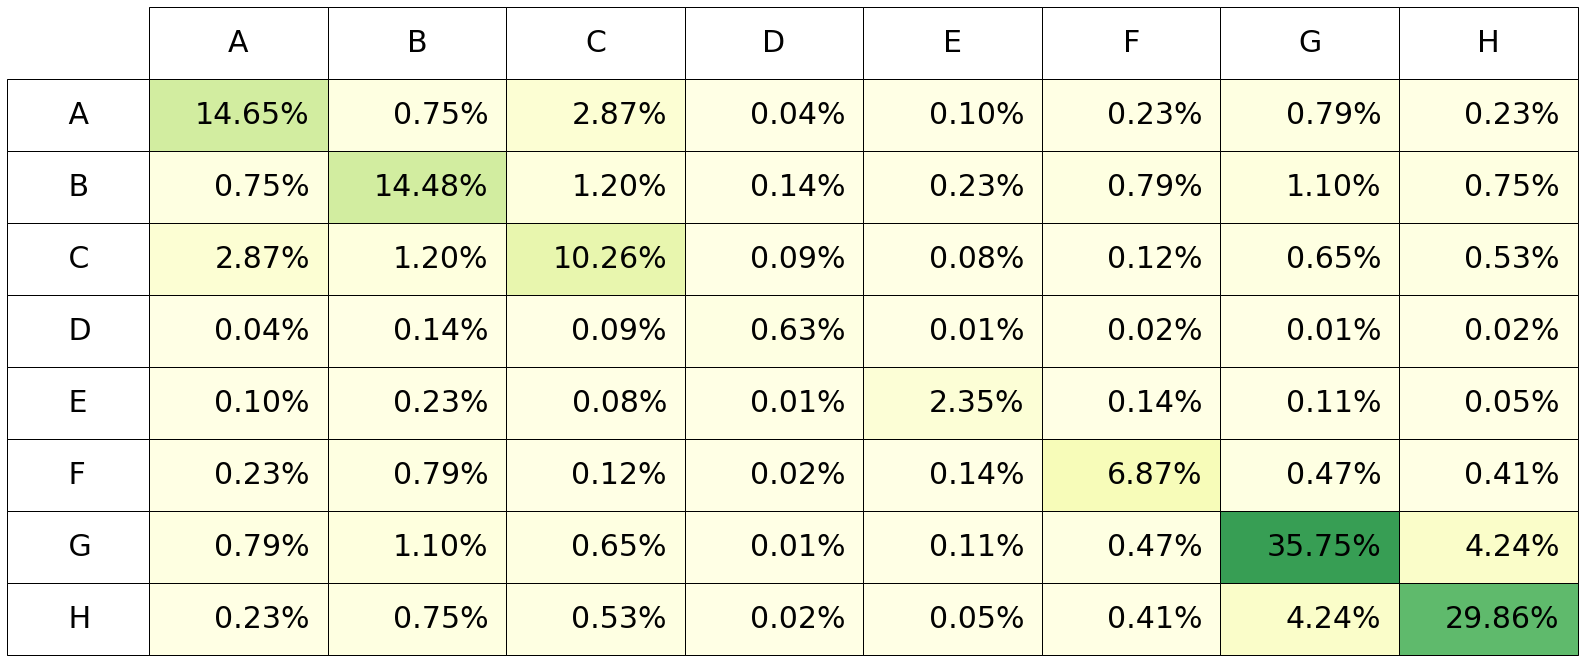

In [43]:
fig = plt.figure(figsize=(16,10), dpi=120)
#ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
vals = overlap_df.values
normal = mpl.colors.Normalize()
normal = mpl.colors.Normalize(vals.min()-1, vals.max()+vals.max()/2)
num_formatter = lambda x: "{:,d}".format(int(x))
percentage_formatter = lambda x: "{:.2%}".format(float(x)/doc_count)
index_formatter = lambda x: "     " + x + "     "

the_table=plt.table(cellText=np.vectorize(percentage_formatter)(vals), 
                    rowLabels=np.vectorize(index_formatter)(overlap_df.index), 
                    colLabels=overlap_df.columns, 
                    colWidths = [0.1]*(vals.shape[1]+3), loc='center',
                    cellColours=plt.cm.YlGn(normal(vals)))
the_table.set_fontsize(30)
the_table.scale(2, 6)
plt.axis("off")
plt.show()

## Class Distribution

In [49]:
i = 0
for classif in sorted(classifications_index.keys()):
    if len(classif) == 4:
        i+= 1
        print "{} : {:,d}, {:.5%}".format(classif, len(set(classifications_index[classif])), float(len(classifications_index[classif]))/doc_count)
print i

A-00 : 5, 0.00025%
A-01 : 47,218, 2.34945%
A-02 : 5, 0.00025%
A-03 : 5, 0.00025%
A-04 : 18, 0.00090%
A-05 : 9, 0.00045%
A-06 : 28, 0.00139%
A-07 : 20, 0.00100%
A-10 : 21, 0.00104%
A-11 : 10, 0.00050%
A-12 : 8, 0.00040%
A-13 : 2, 0.00010%
A-15 : 1, 0.00005%
A-16 : 67, 0.00333%
A-18 : 2, 0.00010%
A-21 : 1,222, 0.06080%
A-22 : 1,034, 0.05145%
A-23 : 6,144, 0.30571%
A-24 : 1,075, 0.05349%
A-25 : 2, 0.00010%
A-26 : 4, 0.00020%
A-27 : 6, 0.00030%
A-28 : 1, 0.00005%
A-29 : 1, 0.00005%
A-31 : 35, 0.00174%
A-32 : 1, 0.00005%
A-33 : 1, 0.00005%
A-34 : 1, 0.00005%
A-35 : 1, 0.00005%
A-36 : 4, 0.00020%
A-37 : 4, 0.00020%
A-38 : 1, 0.00005%
A-41 : 3,714, 0.18480%
A-42 : 898, 0.04468%
A-43 : 2,680, 0.13335%
A-44 : 2,316, 0.11524%
A-45 : 4,341, 0.21600%
A-46 : 1,762, 0.08767%
A-47 : 26,233, 1.30529%
A-48 : 3, 0.00015%
A-51 : 15, 0.00075%
A-52 : 3, 0.00015%
A-53 : 1, 0.00005%
A-54 : 1, 0.00005%
A-55 : 1, 0.00005%
A-56 : 1, 0.00005%
A-60 : 11, 0.00055%
A-61 : 182,351, 9.07332%
A-62 : 4,294, 0.21366%
A-

#### Classes with more than 

### Number of classes/subclasses per section

In [53]:
i = 0
classes_numbers_dict = {}
subclasses_numbers_dict = {}
for sec in sections:
    classes_numbers_dict[sec] = 0
    subclasses_numbers_dict[sec] = 0
for classif in sorted(classifications_index.keys()):
    sect = classif[0]
    if len(classif) == 4:
        classes_numbers_dict[sect] += 1
    if len(classif) == 6:
        subclasses_numbers_dict[sect] += 1
        
for sec in sections:
    print "Section {} : Classes-> {:3,d}, Sections-> {:3,d}".format(sec, classes_numbers_dict[sec], subclasses_numbers_dict[sec])


Section A : Classes->  66, Sections-> 283
Section B : Classes->  70, Sections-> 406
Section C : Classes->  45, Sections-> 218
Section D : Classes->  26, Sections->  80
Section E : Classes->  35, Sections-> 100
Section F : Classes->  46, Sections-> 234
Section G : Classes->  56, Sections-> 297
Section H : Classes->  43, Sections-> 222


## Plot loaded metrics

In [48]:
doc2vec_model_save_location

'/home/local/shalaby/parameter_search_doc2vec_models/sample_0.0001'

<IPython.core.display.Javascript object>


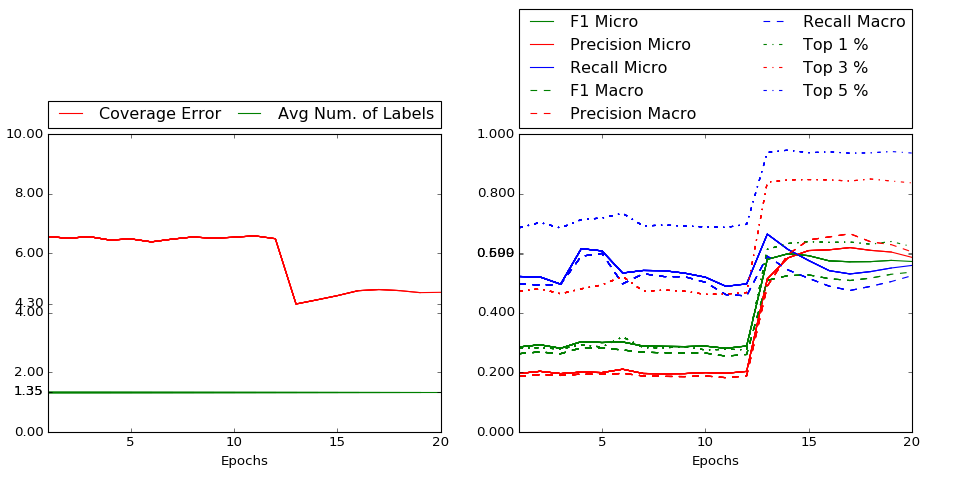

doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}_iter_1000_reg_0.001
Epoch 01: Coverage Error -> 6.56
Epoch 02: Coverage Error -> 6.51
Epoch 03: Coverage Error -> 6.56
Epoch 04: Coverage Error -> 6.45
Epoch 05: Coverage Error -> 6.49
Epoch 06: Coverage Error -> 6.39
Epoch 07: Coverage Error -> 6.48
Epoch 08: Coverage Error -> 6.55
Epoch 09: Coverage Error -> 6.51
Epoch 10: Coverage Error -> 6.54
Epoch 11: Coverage Error -> 6.59
Epoch 12: Coverage Error -> 6.50
Epoch 13: Coverage Error -> 4.30
Epoch 14: Coverage Error -> 4.44
Epoch 15: Coverage Error -> 4.58
Epoch 16: Coverage Error -> 4.75
Epoch 17: Coverage Error -> 4.79
Epoch 18: Coverage Error -> 4.75
Epoch 19: Coverage Error -> 4.68
Epoch 20: Coverage Error -> 4.69


In [32]:
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()
print placeholder_model_name + "_" + GLOBAL_VARS.SVM_MODEL_NAME

for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
    try:
        model_name = placeholder_model_name.format(epoch)
        metrics = pickle.load(open(os.path.join(doc2vec_model_save_location, model_name, GLOBAL_VARS.SVM_MODEL_NAME, METRICS)))
        print "Epoch {:02d}: Coverage Error -> {:.2f}".format(epoch, metrics['coverage_error'])
        graph.add_metrics_to_graph(metrics, epoch)
    except IOError:
        break